In [2]:
import json
import os
import math
from tqdm import tqdm

def load_game(filename: str) -> dict:
    """Load game data from a JSON file."""
    with open(filename, 'r') as file:
        data = json.load(file)
    return data


games = []
game_path = os.path.join(".", "crawler", "games", "classic")

for file in tqdm(os.listdir(game_path)):
    if file.endswith(".json"):
        game_data = load_game(os.path.join(game_path, file))
        games.append(game_data)

print(f"Loaded {len(games)} games.")

players = []
players_name_lvl = {}
for game in tqdm(games):
    for participant in game.get("info").get("participants", []):
        players_name_lvl[participant.get("riotIdGameName") + " #" + participant.get("riotIdTagline")] = participant.get("summonerLevel", 0)

for name, level in players_name_lvl.items():
    players.append((name, level))

print(f"Unique players: {len(players)}")



100%|██████████| 32362/32362 [03:27<00:00, 156.26it/s]


Loaded 32362 games.


100%|██████████| 32362/32362 [00:05<00:00, 5404.14it/s]


Unique players: 235722


In [3]:
from analysis.core import *

In [4]:
len(get_all_participants(games))

100%|██████████| 32362/32362 [00:01<00:00, 25766.80it/s]


235103 total number of players.


235103

In [5]:
print(get_all_gametypes(games))

100%|██████████| 32362/32362 [00:00<00:00, 443529.74it/s]

['MATCHED_GAME', 'CUSTOM_GAME']


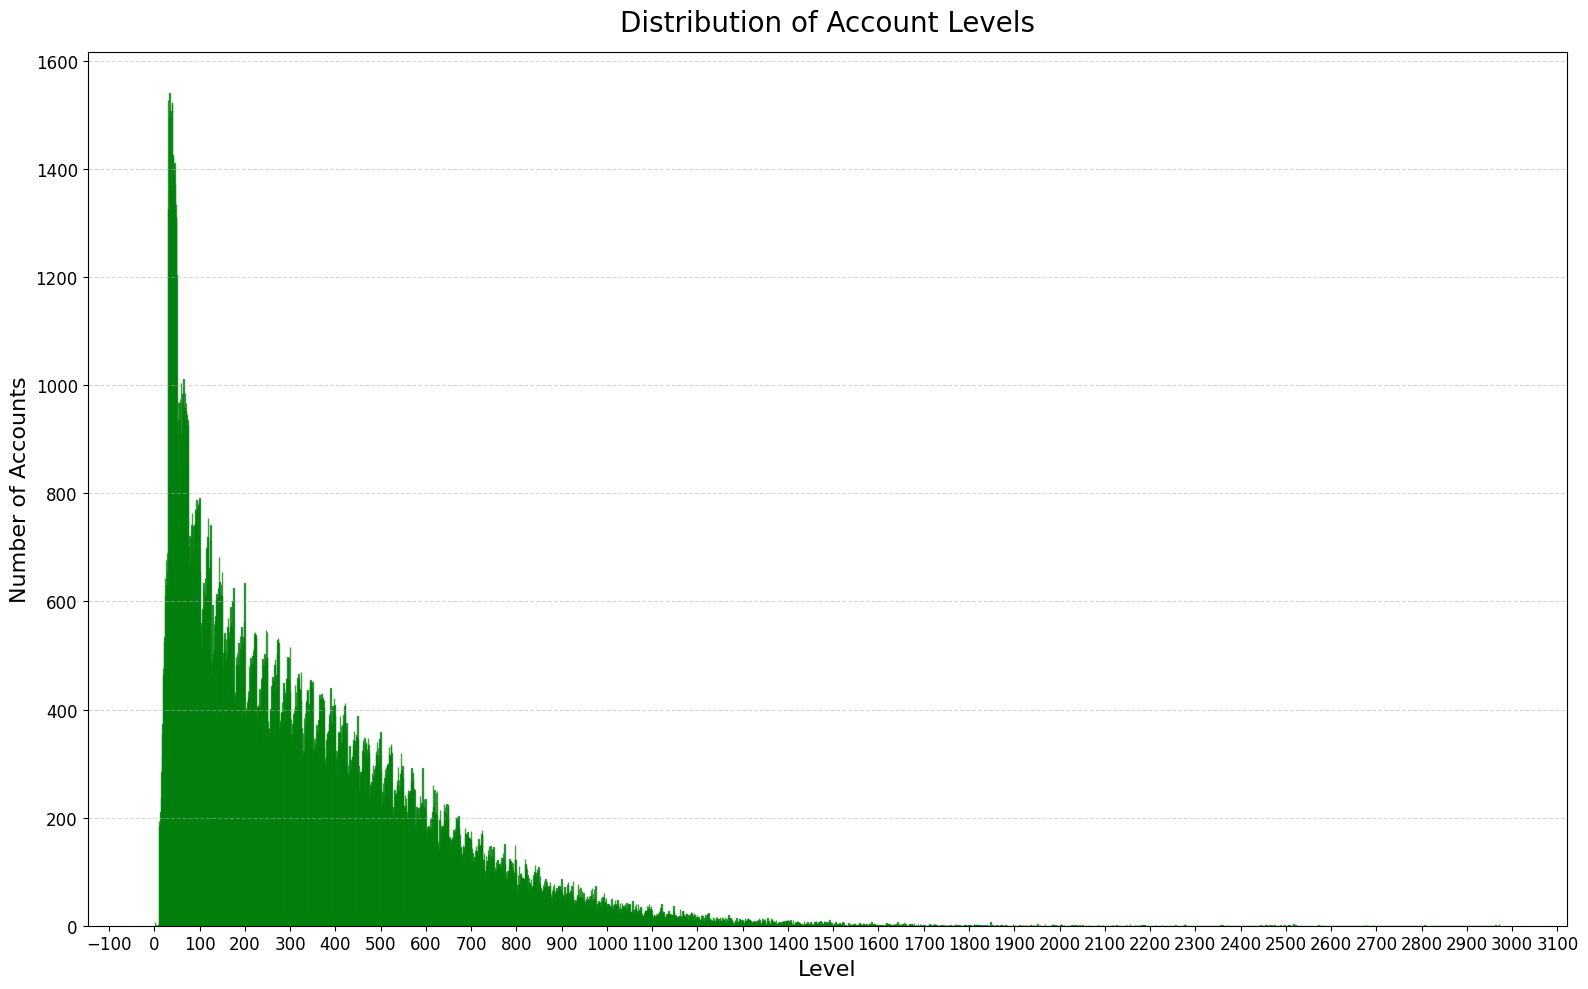

"Qnoxs #17165" Level: 2971


In [6]:
plot_level_distribution(games)
hname, hlevel = get_highest_level_player(games)
print(f"\"{hname}\" Level: {hlevel}")

100%|██████████| 61/61 [00:38<00:00,  1.59it/s]


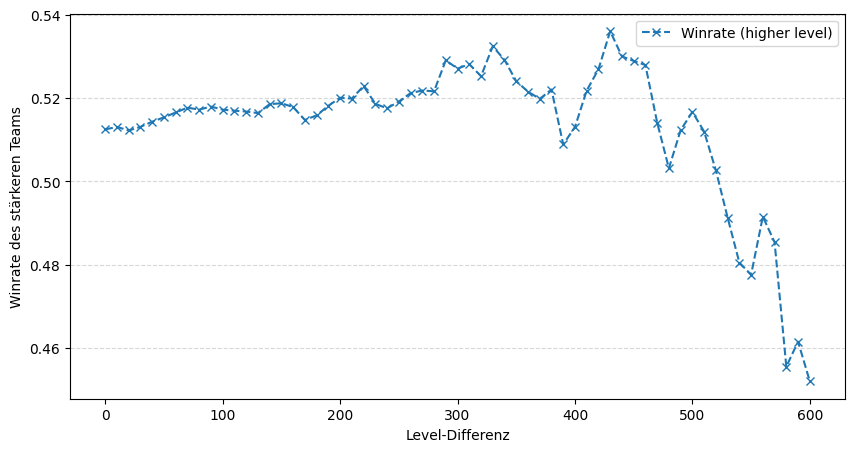

In [7]:
import matplotlib.pyplot as plt

diffs = [i * 10 for i in range(0, 61)]
winrates = [higher_level_winrate(games, d) for d in tqdm(diffs)]

plt.figure(figsize=(10, 5))
plt.plot(diffs, winrates, marker="x", linestyle="--", label="Winrate (higher level)")

#plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
#plt.yticks([i/10 for i in range(0, 11)])

plt.xlabel("Level-Differenz")
plt.ylabel("Winrate des stärkeren Teams")
plt.legend()
plt.show()


100%|██████████| 101/101 [01:08<00:00,  1.48it/s]


[0.508075495049505, 0.508265513733469, 0.5089014470976383, 0.5089114892760044, 0.5092020303166327, 0.5093554354012522, 0.5095183948941789, 0.5096549899860182, 0.5090525163258124, 0.5091350040420372, 0.5096206018615134, 0.5099801261557072, 0.5092166927025218, 0.5099307159353349, 0.5106362636837325, 0.5112342868454914, 0.5116123728291029, 0.5121118343826699, 0.5125725338491296, 0.5138283222400735, 0.5142414491717316, 0.5145420792079208, 0.5148782687105501, 0.5153201475025142, 0.515159963755489, 0.5151009147669522, 0.5164369034994698, 0.515938141076219, 0.5141660507514166, 0.5147485080988917, 0.5145217159605648, 0.5146509891750654, 0.5153613576514191, 0.5161060867797989, 0.5170436444727621, 0.5204931689436855, 0.5204732629625334, 0.5214962351226621, 0.5233265720081136, 0.524416135881104, 0.5228215767634855, 0.5225498699045967, 0.5219755323969189, 0.521594684385382, 0.5234866027125372, 0.5216404886561955, 0.5231050228310502, 0.5226881102814475, 0.5218005651998385, 0.5223024638912489, 0.519

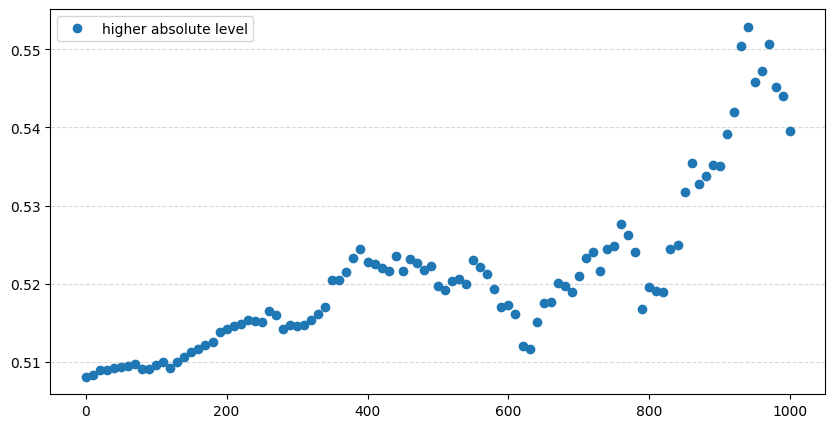

In [8]:
import matplotlib.pyplot as plt

diffs = [i * 10 for i in range(0, 101)]
winrates_higher = [higher_absolute_level_winrate(games, d) for d in tqdm(diffs)]

print(winrates_higher)
plt.figure(figsize=(10, 5))

plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/100 for i in range(0, 101)])
plt.plot(diffs, winrates_higher, marker="o", linestyle="", label="higher absolute level")
plt.legend()
plt.show()

(21828.2, 18631.0)
[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000]
31063 Wins with higher champion level and 1267 Wins with lower champion level of 32330 games
30485 Wins with higher champion level and 1047 Wins with lower champion level of 31532 games
30186 Wins with higher champion level and 934 Wins with lower champion level of 31120 games
29934 Wins with higher champion level and 844 Wins with lower champion level of 30778 games
29682 Wins with higher champion level and 772 Wins with lower champion level of 30454 games
29415 Wins with higher champion level and 698 Wins with lower champion level of 30113 games
29115 Wins with higher champion level and 624 Wins with lower champion l

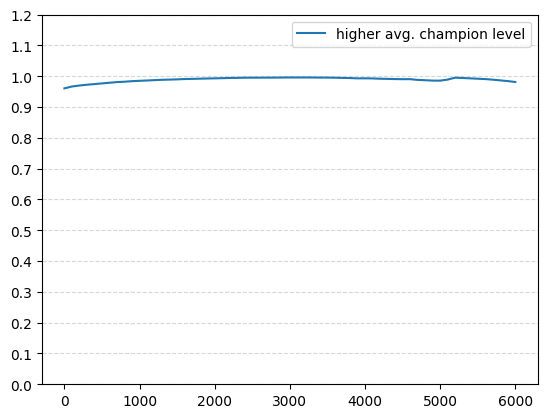

In [9]:
import matplotlib.pyplot as plt
print(get_team_champion_levels(games[1]))
diffs = [i * 100 for i in range(0, 61)]
winrates_higher = []
winrates_lower = []
print(diffs)
for d in diffs:
    wr = higher_champion_level_winrate(games, d)
    winrates_higher.append(wr)
print(winrates_higher)
plt.ylim(0, 1.2)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/10 for i in range(0, 13)])
plt.plot(diffs, winrates_higher, label="higher avg. champion level")
#plt.plot(diffs, winrates_lower, label="lower avg. level")
plt.legend()
plt.show()

In [10]:
print(get_percentage_of_surrendered_games(games))

0.28861009826339534


100%|██████████| 32362/32362 [00:00<00:00, 56076.61it/s]


0.3612591115614683


100%|██████████| 32362/32362 [00:00<00:00, 129565.63it/s]


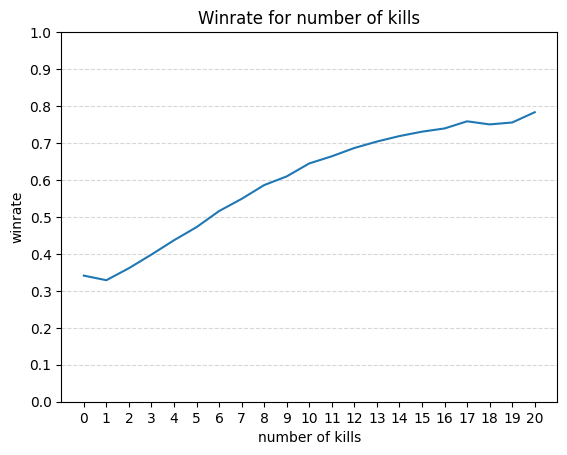

In [11]:
print(get_winratio_for_nr_kills(games, 2))
kills = [i for i in range(0, 21)]
winratio = [get_winratio_for_nr_kills(games, k) for k in kills]
plt.yticks([i/10 for i in range(0, 13)])
plt.xticks(kills)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.title("Winrate for number of kills")
plt.xlabel("number of kills")
plt.ylabel("winrate")
plt.plot(kills, winratio)
plt.show()

100%|██████████| 32362/32362 [00:00<00:00, 125731.95it/s]


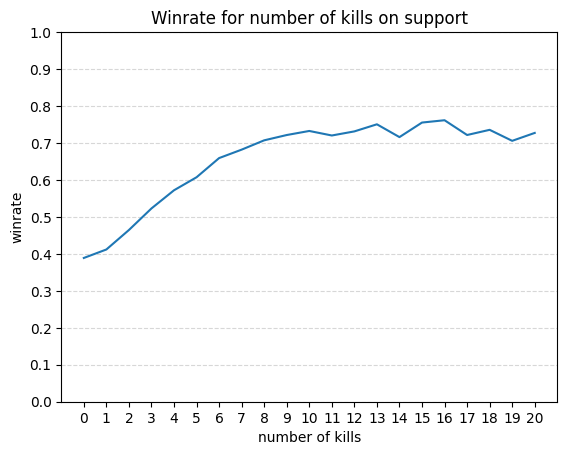

In [12]:
kills = [i for i in range(0, 21)]
winratio = [get_winratio_for_nr_kills_and_role(games, k, "SUPPORT") for k in kills]
plt.yticks([i/10 for i in range(0, 13)])
plt.xticks(kills)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.title("Winrate for number of kills on support")
plt.xlabel("number of kills")
plt.ylabel("winrate")
plt.plot(kills, winratio)
plt.show()

100%|██████████| 32362/32362 [00:00<00:00, 131065.42it/s]


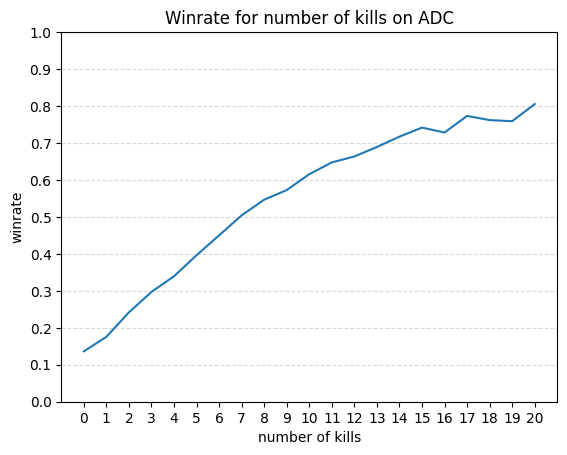

In [13]:
kills = [i for i in range(0, 21)]
winratio = [get_winratio_for_nr_kills_and_role(games, k, "CARRY") for k in kills]
plt.yticks([i/10 for i in range(0, 13)])
plt.xticks(kills)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.title("Winrate for number of kills on ADC")
plt.xlabel("number of kills")
plt.ylabel("winrate")
plt.plot(kills, winratio)
plt.show()